In [1]:
import os
import cv2
import numpy as np
import scipy
from matplotlib import pyplot as plt
import seaborn as sns; sns.set_style("white")
from PIL import Image
import skimage

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams["figure.dpi"] = 125
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams['image.cmap'] = 'gray' # grayscale looks better
from itertools import cycle
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

input_folder = 'assignment_2tasks_1909/image_cropped'
# os.listdir(input_folder)
list_files = os.listdir(input_folder)
np_data = [cv2.imread(input_folder + "/" + f) for f in list_files]

In [3]:
# list_files
# avr_h, avr_w = 0, 0
# for img in np_data:
#     h, w = img.shape[:2]
#     avr_h += h
#     avr_w += w
# print(int(avr_h / 49), int(avr_w/ 49))

In [34]:
def get_angle(lines):
    # h: horizontal, v: vertical
    filters   = {'h': [], 'v': []}
    theta_min = {'h': 63 * np.pi / 180, 'v': 27 * np.pi / 180} 
    theta_max = {'h': 117 * np.pi /180, 'v': 153 * np.pi / 180}
    theta_avr = {'h': 0, 'v': 0}
    theta_deg = {'h': 0, 'v': 0}
    
    if lines is None:
        return 0
    for line in lines:
        _, theta = line[0]
        if theta > theta_min['h'] and theta < theta_max['h']:
            filters['h'].append(theta)
            theta_avr['h'] += theta
        if theta < theta_min['v'] and theta > theta_max['v']:
            filters['v'].append(theta)
            theta_avr['v'] += theta

            
    if len(filters['h']) > 0: 
        theta_avr['h'] /= len(filters['h'])
        theta_deg['h'] = (theta_avr['h'] / np.pi * 180) - 90
        
    if len(filters['v']) > 0:
        theta_avr['v'] /= len(filters['v'])
        theta_deg['v'] = (theta_avr['v'] / np.pi * 180)
    
    angle = (theta_deg['h'] + theta_deg['v']) / 2
    if theta_deg['h'] == 0 or theta_deg['v'] == 0:
            return theta_deg['h'] if theta_deg['v'] == 0 else theta_deg['v']
    
    return angle


def show_houghlines(img, lines):
    if lines is None:
        return 0
    for line in lines:
        r, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta) 
        x0 = a*r
        y0 = b*r
        x1 = int(x0 + 1000*(-b)) 
        y1 = int(y0 + 1000*(a)) 
        x2 = int(x0 - 1000*(-b)) 
        y2 = int(y0 - 1000*(a)) 
        cv2.line(img, (x1,y1), (x2,y2), (0,0,255), 2)
    plt.imshow(img)
    
    
def hough_lines(edge):
    lines = cv2.HoughLines(edge, 1, np.pi / 180, 117)
    return lines


def denoise(image):
    norm = skimage.exposure.rescale_intensity(image)
    gray = cv2.cvtColor(norm, cv2.COLOR_BGR2GRAY)
#     blur = cv2.GaussianBlur(gray, (5,5), 0)
    blur = cv2.bilateralFilter(gray,10,45,45)
    edge = cv2.Canny(blur, 50, 150, apertureSize = 3)
    return blur, edge, norm


def rotate(blur, edge, norm):
    lines = hough_lines(edge)
    angle = get_angle(lines)
#     show_houghlines(image, lines)
    h, w = edge.shape[:2]
    center = (w / 2, h / 2)    
    transform_matrix = cv2.getRotationMatrix2D(center, angle, 1)
    dest = cv2.warpAffine(blur, transform_matrix, (w, h))
    norm = cv2.warpAffine(norm, transform_matrix, (w, h))
    return dest, norm


def preprocess(image):
    blur, edge, norm = denoise(image)
    rotated, norm = rotate(blur, edge, norm)
    rotated = skimage.exposure.rescale_intensity(rotated)
    thresh = cv2.adaptiveThreshold(rotated, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 299, -13)
    return blur, thresh, rotated, norm


def bbox(thresh, img):
    extra = 7
    contours, hierarchy = cv2.findContours(thresh, 1, 2)
#     cnt = contours[0]
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(img, (x - extra, y - extra), (x + w + extra, y + h + extra), (0, 255, 0), 1)
#         print(x,y,w,h)
    plt.imshow(img)
#     return dest
    

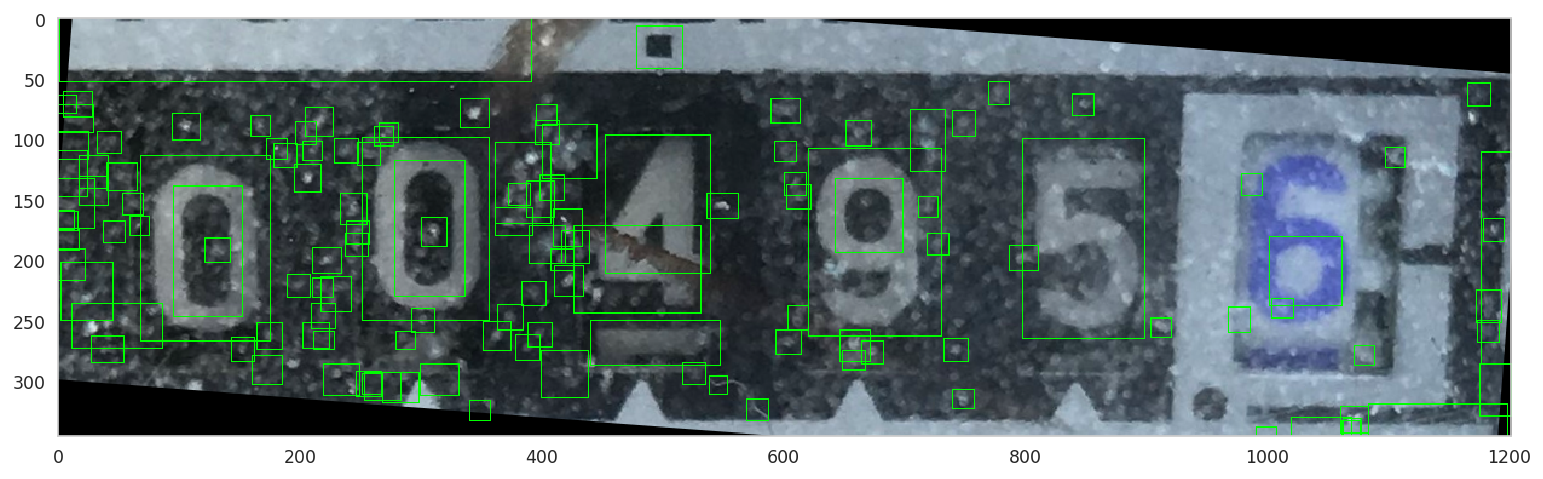

In [35]:
test = np_data[2]
blur, thresh, rotated, norm = preprocess(test)
dest = bbox(thresh, norm)
# fig, ax = plt.subplots(1,3, figsize=(15,20))
# ax1, ax2, ax3 = ax
# ax1.imshow(dest)
# ax2.imshow(thresh)
# ax3.imshow(edge)

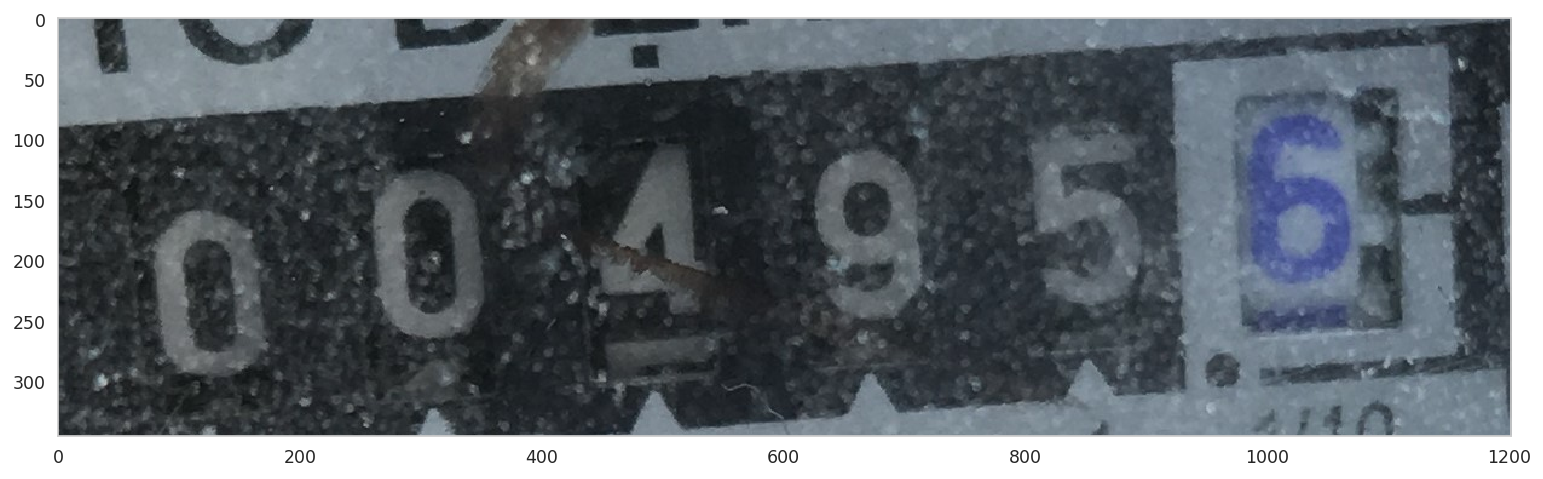

In [33]:
plt.imshow(test)

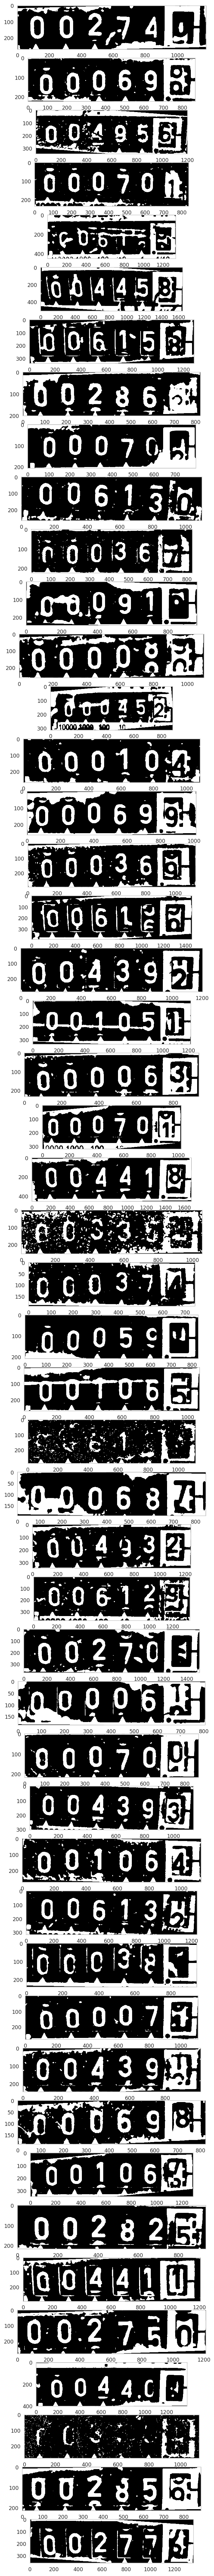

In [33]:
fig, axes = plt.subplots(49, 1, figsize=(70, 90))
for ax1, img in zip(axes, np_data):
    _,t,y = preprocess(img)
    ax1.imshow(t)

In [ ]:
bins_8bit = np.linspace(0, 255, 26)
fig, axes = plt.subplots(10, 3)# figsize=(15, 20))
fig.set_figheight(20)
fig.set_figwidth(15)
for (ax1, ax2, ax3), c_img in zip(axes, np_data):
    ax1.imshow(c_img)
    gray_img = cv2.cvtColor(c_img, cv2.COLOR_BGR2GRAY)
    ax2.imshow(gray_img)
    ax3.hist(gray_img.ravel(), bins_8bit)

## Histogram normalization

In [ ]:
from skimage.exposure import rescale_intensity

In [ ]:
np.random.seed(2019)
xx = np.stack([np.arange(5)]*5, -1)
yy = xx.T
bins_sample_8bit = np.linspace(0, 255, 8)
sample_img = (25*(xx+yy)+np.random.uniform(-10, 10, size=(5, 5))).astype('uint8')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3))
sns.heatmap(sample_img, annot=True,fmt='02d', ax=ax1, cmap='viridis')
ax2.hist(sample_img.ravel(), bins_sample_8bit, label='Original', alpha=1)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))
sns.heatmap(sample_img, annot=True,fmt='02d', ax=ax1, cmap='viridis')
ax1.set_title('Original')
ax1.axis('off')
trans_img = rescale_intensity(sample_img)
sns.heatmap(trans_img, annot=True,fmt='02d', ax=ax2, cmap='viridis')
ax2.set_title('Normalized')
ax2.axis('off')
ax3.hist(sample_img.ravel(), bins_sample_8bit, label='Original', alpha=1)
ax3.hist(trans_img.ravel(), bins_sample_8bit, label='Normalized', alpha=0.5)
ax3.legend()

In [ ]:
fig, m_axs = plt.subplots(10, 2, figsize=(15, 20))
for (c_ax, d_ax), img in zip(m_axs, np_data):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    n_img = skimage.exposure.rescale_intensity(gray_img)
    c_ax.imshow(gray_img)
    d_ax.imshow(n_img)

## Remove noise

In [ ]:
fig, m_axs = plt.subplots(5, 2, figsize=(15, 10))
for (c_ax, d_ax), img in zip(m_axs, np_data):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.blur(gray_img,(15,15))
    c_ax.imshow(gray_img)
    d_ax.imshow(blur)


In [ ]:
fig, m_axs = plt.subplots(5, 2, figsize=(15, 10))
for (c_ax, d_ax), img in zip(m_axs, np_data):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.bilateralFilter(gray_img,20,75,75)
    c_ax.imshow(gray_img)
    d_ax.imshow(blur)


## Edge detection

In [ ]:
fig, m_axs = plt.subplots(5, 3, figsize=(15, 10))
for (c_ax, ax2,d_ax), img in zip(m_axs, np_data):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.bilateralFilter(gray_img,10,50,50)
    ax2.imshow(blur)
    edges = cv2.Canny(blur,35,175)
    c_ax.imshow(gray_img)
    d_ax.imshow(edges)
